In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import (
    AutoTokenizer,
    BitsAndBytesConfig,
)

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from Levenshtein import ratio
from msapy import msa, utils
import pickle as pkl
import time
from itertools import product
from functools import cache, partial

from transformers.models.mixtral.modeling_mixtral import *
from transformers.models.mixtral import *
from tasks import *
from visual_config import *

import warnings
warnings.filterwarnings( "ignore" )

In [3]:
SEED = 2810

In [4]:
# Initial Setup
num_permutations = 1000 # Set this to 1000 to perform the full analysis. This takes a while to run. For the demonstration purpose, we set it to 1.
lesion_dictionary = defaultdict(list) # Initialize the lesion dictionary as empty meaning the network is intact
with torch.no_grad():
    torch.cuda.empty_cache()

In [5]:
device_map = "cuda"
model_path = "mistralai/Mixtral-8x7B-Instruct-v0.1"
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
)

In [6]:
num_arithmetic_operations_questions_train = 30
num_arithmetic_operations_questions_test = 50
total_arithmetic_operations_questions = num_arithmetic_operations_questions_train + num_arithmetic_operations_questions_test
num_arithmetic_operators = 3

num_sentences_per_language = 15
num_languages = 5

In [7]:
class LesionedMixtralSparseMoeBlock(MixtralSparseMoeBlock):
    def __init__(self, config, layer_idx):
        super().__init__(config)
        self.layer_idx = layer_idx
    
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        ## Most of the code is copied from the original implementation
        batch_size, sequence_length, hidden_dim = hidden_states.shape
        if self.training and self.jitter_noise > 0:
            hidden_states *= torch.empty_like(hidden_states).uniform_(1.0 - self.jitter_noise, 1.0 + self.jitter_noise)
        hidden_states = hidden_states.view(-1, hidden_dim)
        # router_logits: (batch * sequence_length, n_experts)
        router_logits = self.gate(hidden_states)

        routing_weights = F.softmax(router_logits, dim=1, dtype=torch.float)
        routing_weights, selected_experts = torch.topk(routing_weights, self.top_k, dim=-1)
        routing_weights /= routing_weights.sum(dim=-1, keepdim=True)
        # we cast back to the input dtype
        routing_weights = routing_weights.to(hidden_states.dtype)

        final_hidden_states = torch.zeros(
            (batch_size * sequence_length, hidden_dim), dtype=hidden_states.dtype, device=hidden_states.device
        )

        # One hot encode the selected experts to create an expert mask
        # this will be used to easily index which expert is going to be sollicitated
        expert_mask = torch.nn.functional.one_hot(selected_experts, num_classes=self.num_experts).permute(2, 1, 0)

        # Loop over all available experts in the model and perform the computation on each expert
        for expert_idx in range(self.num_experts):
            # if the current expert is lesioned, skip it. This is the only change I made
            if expert_idx in lesion_dictionary[self.layer_idx]:
                continue 

            expert_layer = self.experts[expert_idx]
            idx, top_x = torch.where(expert_mask[expert_idx])

            # Index the correct hidden states and compute the expert hidden state for
            # the current expert. We need to make sure to multiply the output hidden
            # states by `routing_weights` on the corresponding tokens (top-1 and top-2)
            current_state = hidden_states[None, top_x].reshape(-1, hidden_dim)
            current_hidden_states = expert_layer(current_state) * routing_weights[top_x, idx, None]

            # However `index_add_` only support torch tensors for indexing so we'll use
            # the `top_x` tensor here.
            final_hidden_states.index_add_(0, top_x, current_hidden_states.to(hidden_states.dtype))
        final_hidden_states = final_hidden_states.reshape(batch_size, sequence_length, hidden_dim)
        return final_hidden_states, router_logits

class LesionedMixtralDecoderLayer(MixtralDecoderLayer):
    def __init__(self, config: MixtralConfig, layer_idx: int):
        super().__init__(config, layer_idx)
        self.block_sparse_moe = LesionedMixtralSparseMoeBlock(config, layer_idx)

class LesionedMixtralModel(MixtralModel):
    def __init__(self, config: MixtralConfig):
        super().__init__(config)
        self._no_split_modules = ["LesionedMixtralDecoderLayer"]
        self.layers = nn.ModuleList(
            [LesionedMixtralDecoderLayer(config, layer_idx) for layer_idx in range(config.num_hidden_layers)]
        )
        self.post_init()

class LesionedMixtralForCausalLM(MixtralForCausalLM):
    _tied_weights_keys = ["lm_head.weight"]

    def __init__(self, config):
        super().__init__(config)
        self.model = LesionedMixtralModel(config)
        # Initialize weights and apply final processing
        self.post_init()


In [8]:
lesioned_model = LesionedMixtralForCausalLM.from_pretrained(
        model_path,
        device_map="cuda",
        quantization_config=quantization_config,
)

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

In [10]:
rng = np.random.default_rng(SEED)

addition_messages_train, addition_answers_train, addition_messages_test, addition_answers_test = get_arithmetic_messages(*get_addition_question(rng, size=total_arithmetic_operations_questions), "+", num_training_examples=num_arithmetic_operations_questions_train)
subtraction_messages_train, subtraction_answers_train, subtraction_messages_test, subtraction_answers_test = get_arithmetic_messages(*get_subtraction_question(rng, size=total_arithmetic_operations_questions), "-", num_training_examples=num_arithmetic_operations_questions_train)
multiplication_messages_train, multiplication_answers_train, multiplication_messages_test, multiplication_answers_test = get_arithmetic_messages(*get_multiplication_question(rng, size=total_arithmetic_operations_questions), "*", num_training_examples=num_arithmetic_operations_questions_train)

In [11]:
all_arithmetic_messages_train = addition_messages_train + subtraction_messages_train + multiplication_messages_train
all_arithmetic_messages_test = addition_messages_test + subtraction_messages_test + multiplication_messages_test

all_arithmetic_answers_train = np.concatenate([addition_answers_train, subtraction_answers_train, multiplication_answers_train])
all_arithmetic_answers_test = np.concatenate([addition_answers_test, subtraction_answers_test, multiplication_answers_test])

all_arithmetic_messages_train = [tokenizer.apply_chat_template(message, tokenize=False) for message in all_arithmetic_messages_train]
all_arithmetic_messages_test = [tokenizer.apply_chat_template(message, tokenize=False) for message in all_arithmetic_messages_test]

arithmetic_inputs_train = tokenizer(all_arithmetic_messages_train, return_tensors="pt", padding=True).to(device_map)
arithmetic_inputs_test = tokenizer(all_arithmetic_messages_test, return_tensors="pt", padding=True).to(device_map)

In [12]:
def get_operation_wise_accuracy(test=False) -> np.ndarray:
    answers = all_arithmetic_answers_test if test else all_arithmetic_answers_train
    inputs = arithmetic_inputs_test if test else arithmetic_inputs_train
    outputs = lesioned_model.generate(**inputs, max_new_tokens=9, pad_token_id = tokenizer.eos_token_id)
    outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return list(np.array([get_arithmetic_accuracy(output, answer) for output, answer in zip(outputs, answers)]).reshape(3, -1).mean(axis=1))

In [13]:
languaged_sentences_data = pd.read_csv("sentences.csv")

In [14]:
np.random.seed(SEED)

language_sentences = get_language_sentence_message("eng", languaged_sentences_data, num_sentences=num_sentences_per_language)
language_sentences += get_language_sentence_message("deu", languaged_sentences_data, num_sentences=num_sentences_per_language)
language_sentences += get_language_sentence_message("fra", languaged_sentences_data, num_sentences=num_sentences_per_language)
language_sentences += get_language_sentence_message("spa", languaged_sentences_data, num_sentences=num_sentences_per_language)
language_sentences += get_language_sentence_message("ita", languaged_sentences_data, num_sentences=num_sentences_per_language)

language_sentences = [tokenizer.apply_chat_template(message, tokenize=False) for message in language_sentences]

language_inputs = tokenizer(language_sentences, return_tensors="pt", padding=True).to(device_map)
languages = ["english", "deutsch", "français", "español", "italiano"]

In [15]:
def get_language_wise_accuracy() -> np.ndarray:
    outputs = lesioned_model.generate(**language_inputs, max_new_tokens=3, pad_token_id = tokenizer.eos_token_id)
    outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    outputs = [extract_language_from_output(output) for output in outputs]
    language_wise_accuracy = []
    for i, language in enumerate(languages):
        outputs_language = outputs[i*num_sentences_per_language:(i+1)*num_sentences_per_language]
        num_right_answers_language = len([1 for output in outputs_language if language in output])
        language_wise_accuracy.append(num_right_answers_language / num_sentences_per_language)
    return language_wise_accuracy

In [16]:
countries_capitals_data = pd.read_csv("country_capitals.csv")
countries_capitals_data.capital = countries_capitals_data.capital.str.lower()
countries_capitals_data.sample(5)

,country,capital
16,Italy,rome
10,Germany,berlin
15,France,paris
7,Japan,tokyo
4,Bangladesh,dhaka


In [17]:
country_capital_messages = get_countries_capitals_messages(countries_capitals_data)
country_capital_messages = [tokenizer.apply_chat_template(message, tokenize=False) for message in country_capital_messages]

country_capital_inputs = tokenizer(country_capital_messages, return_tensors="pt", padding=True).to(device_map)
capitals_answers = countries_capitals_data["capital"].values

In [18]:
def get_country_capital_accuracy() -> list:
    outputs = lesioned_model.generate(**country_capital_inputs, max_new_tokens=3, pad_token_id = tokenizer.eos_token_id)
    outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    outputs = [extract_capital_from_output(output) for output in outputs]
    correct_answers = len([1 for output, capital in zip(outputs, capitals_answers) if capital in output])
    return [correct_answers / len(outputs)]

In [19]:
def complements_to_lesion_dict(coplements):
    global lesion_dictionary
    lesion_dictionary = defaultdict(list)
    for c in coplements:
        lesion_dictionary[c[0]].append(c[1])

In [20]:
@cache
@torch.no_grad()
def objective_function(coplements,test: bool = False):
    global lesion_dictionary
    complements_to_lesion_dict(coplements)
    operation_wise_accuracy = get_operation_wise_accuracy(test=test)
    language_wise_accuracy = get_language_wise_accuracy()
    country_capital_accuracy = get_country_capital_accuracy()

    return np.array(operation_wise_accuracy + language_wise_accuracy + country_capital_accuracy)

objective_function_test = partial(objective_function, test=True)

In [21]:
unlesioned_model_performance = LesionedModelPerformance(*list(objective_function(())))
unlesioned_model_performance

LesionedModelPerformance(
  addition_accuracy=0.9185,
  subtraction_accuracy=0.9034,
  multiplication_accuracy=0.5775,
  english_accuracy=1.0000,
  german_accuracy=1.0000,
  french_accuracy=1.0000,
  spanish_accuracy=0.7333,
  italian_accuracy=1.0000,
  country_capital_accuracy=0.7000
)

In [22]:
(0.9185+0.9034+0.5775+1.0000+1.0000+1.0000+0.7333+1.0000+0.7000) / 9

0.8703

In [23]:
all_performance_metrics = [f.name for f in fields(LesionedModelPerformance)]

In [24]:
elements = list(product(list(range(32)), list(range(8))))

In [ ]:
shapley_table = msa.interface(
    n_permutations=num_permutations,
    elements=elements,
    objective_function=objective_function,
)

In [27]:
time_finished = time.strftime('%Y%m%d-%H%M%S')

In [ ]:
shapley_table.columns = shapley_table.columns.astype(str)
shapley_df_formatted = pd.DataFrame(shapley_table).melt(ignore_index=False, var_name="Layer_Expert", value_name="Contribution")
task_mapping = {i: performance_metric for i, performance_metric in enumerate(all_performance_metrics)}
shapley_df_formatted['Performance Metric'] = shapley_df_formatted.index.map(task_mapping)
shapley_df_formatted['Layer'], shapley_df_formatted['Expert'] = zip(*shapley_df_formatted['Layer_Expert'].apply(eval))
shapley_df_formatted.drop(columns=["Layer_Expert"], inplace=True)
shapley_df_formatted.to_csv(f"shapley_analysis.csv", index=False)

In [30]:
shapley_df_formatted = pd.read_csv("shapley_analysis.csv")
shapley_df_formatted

,Contribution,Performance Metric,Layer,Expert
0,0.000512,addition,0,0
1,0.000751,subtraction,0,0
2,0.001239,multiplication,0,0
3,0.000667,english,0,0
4,-0.000762,german,0,0
...,...,...,...,...
2299,-0.000476,german,31,7
2300,0.001810,french,31,7
2301,-0.000381,spanish,31,7
2302,0.007143,italian,31,7


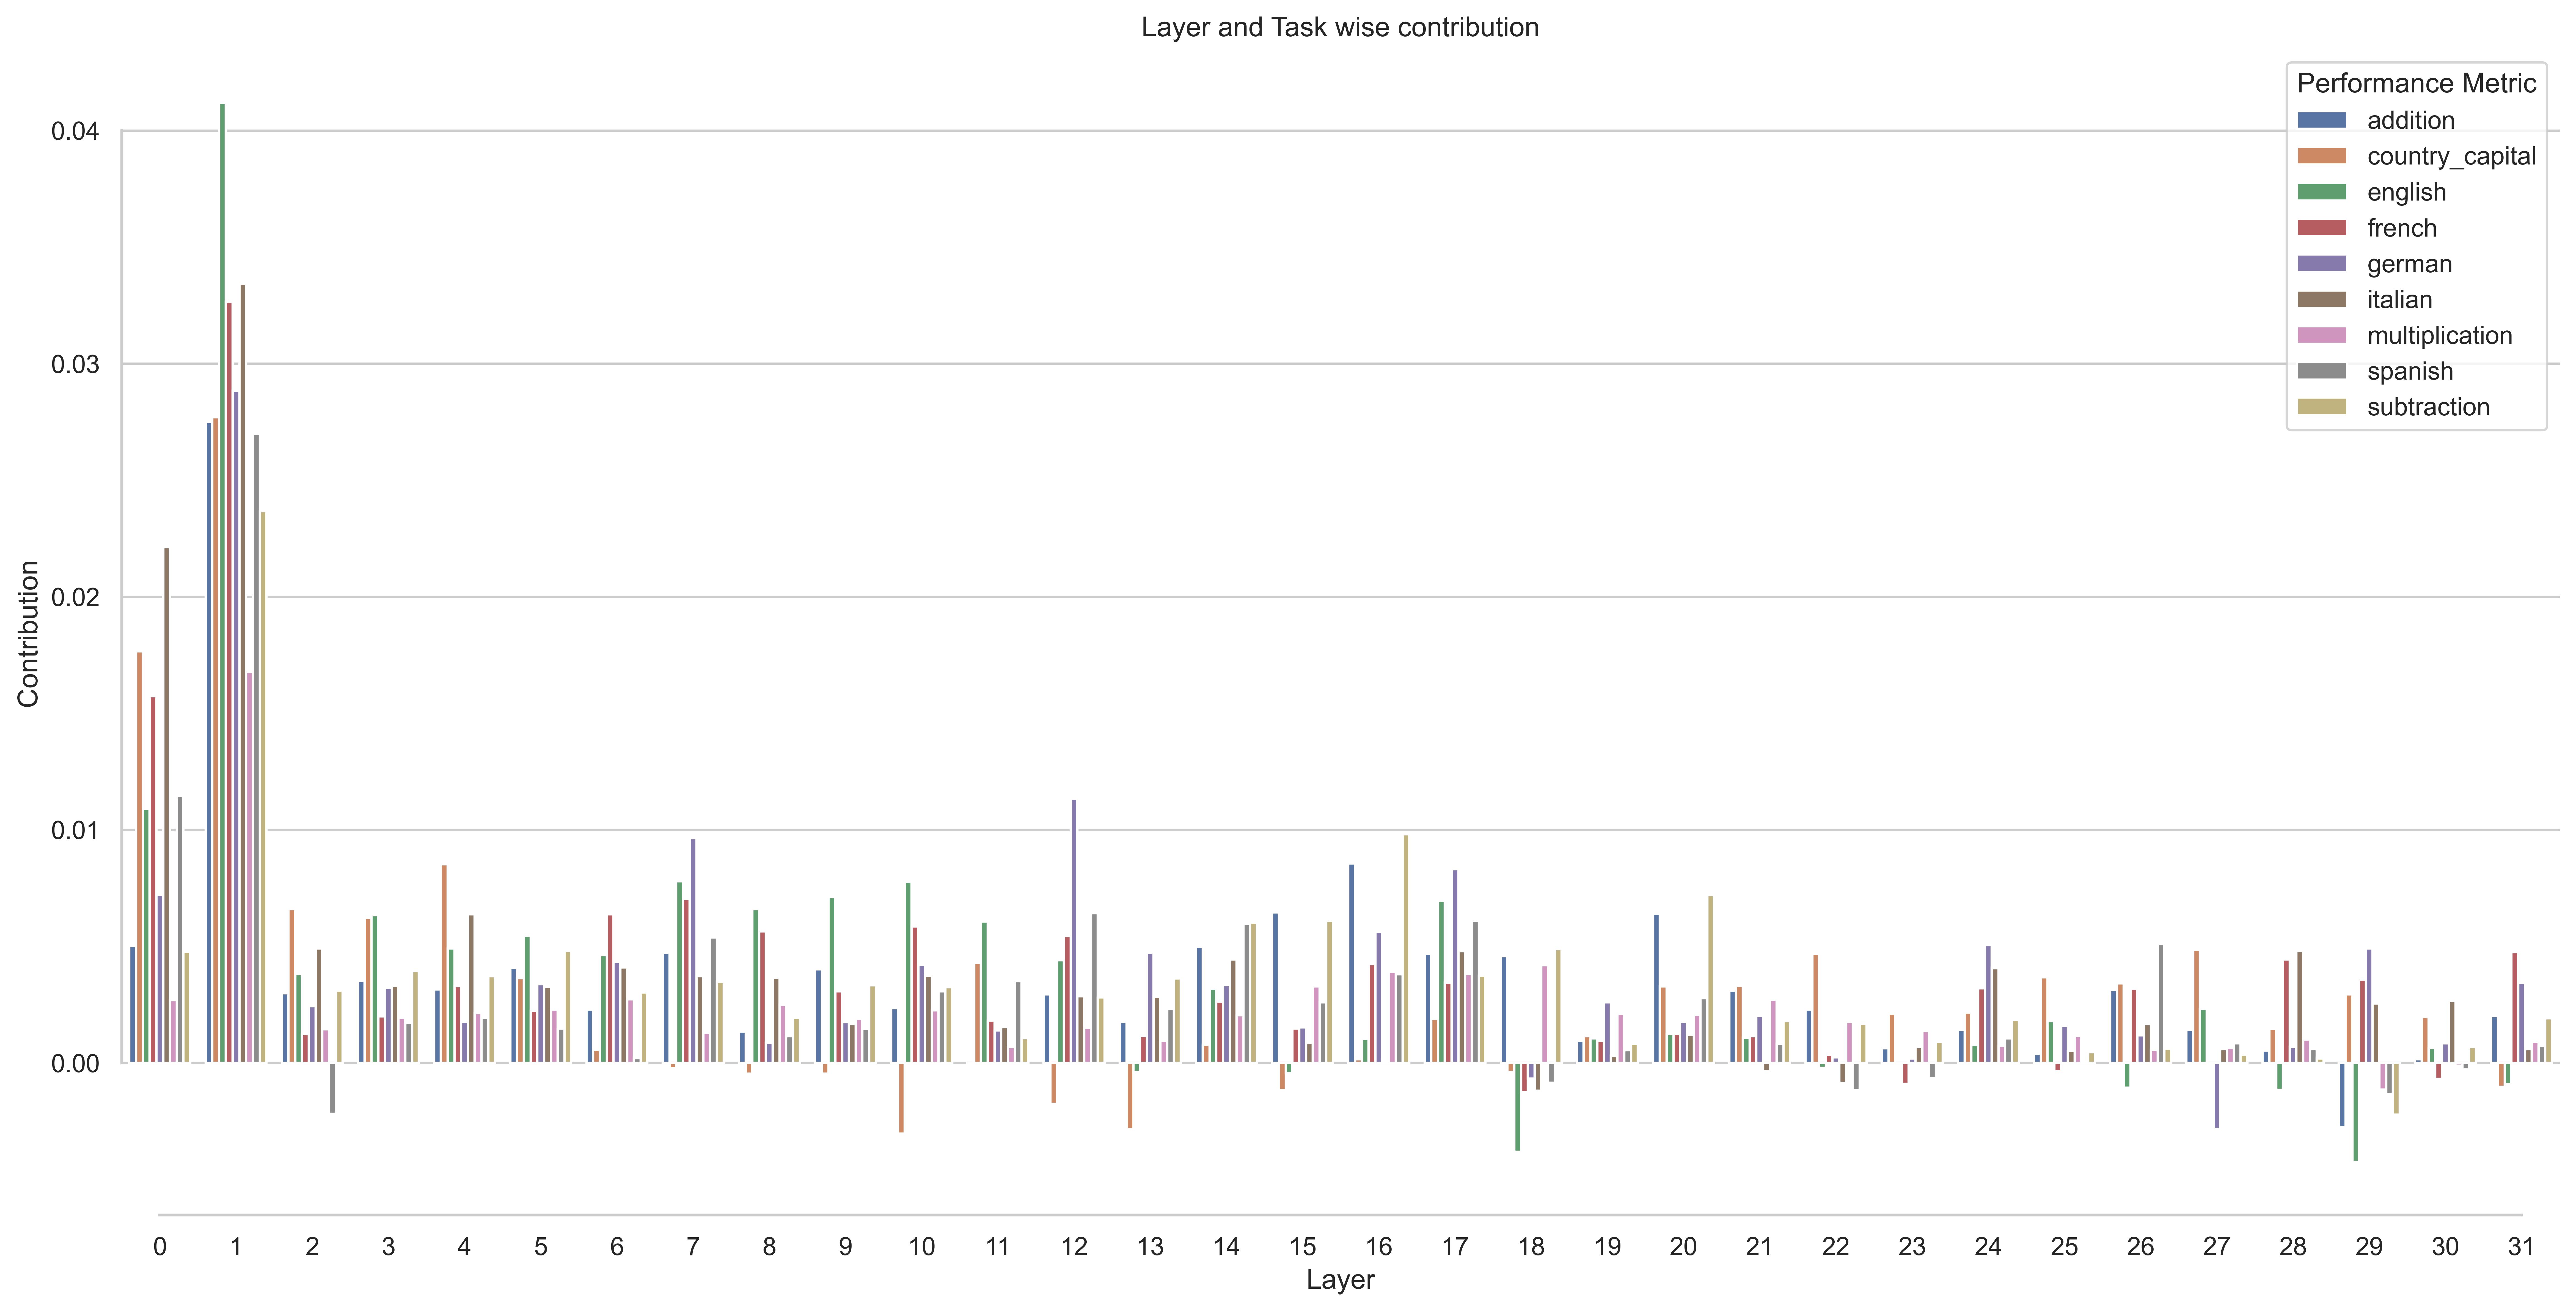

In [29]:
layer_and_task_wise_contributions = shapley_df_formatted.groupby(["Layer", "Performance Metric"])["Contribution"].mean().reset_index()

plt.figure(figsize=(40*CM,20*CM), dpi = 600)
sns.set_theme(style="whitegrid")
sns.barplot(data=layer_and_task_wise_contributions, x="Layer", y="Contribution", hue="Performance Metric")
sns.despine(offset=0, trim=True)
plt.tight_layout(pad=1)
plt.title("Layer and Task wise contribution")
plt.show()

In [31]:
language_tasks = ["english", "french", "spanish", "italian", "german"]
language_shapley_df = shapley_df_formatted[shapley_df_formatted["Performance Metric"].isin(language_tasks)]
arithmetic_tasks = ["addition", "subtraction", "multiplication"]
arithmetic_shapley_df = shapley_df_formatted[shapley_df_formatted["Performance Metric"].isin(arithmetic_tasks)]
world_tasks = ["country_capital"]
world_shapley_df = shapley_df_formatted[shapley_df_formatted["Performance Metric"].isin(world_tasks)]

average_arithmetic_shapley_df = arithmetic_shapley_df.groupby(["Layer", "Expert"])["Contribution"].mean().reset_index()
average_arithmetic_shapley_df["Contribution Normalized"] = average_arithmetic_shapley_df["Contribution"] / average_arithmetic_shapley_df["Contribution"].sum()
average_arithmetic_shapley_df["Domain"] = "Arithmetic"
average_language_shapley_df = language_shapley_df.groupby(["Layer", "Expert"])["Contribution"].mean().reset_index()
average_language_shapley_df["Contribution Normalized"] = average_language_shapley_df["Contribution"] / average_language_shapley_df["Contribution"].sum()
average_language_shapley_df["Domain"] = "Language"
average_world_shapley_df = world_shapley_df.groupby(["Layer", "Expert"])["Contribution"].mean().reset_index()
average_world_shapley_df["Contribution Normalized"] = average_world_shapley_df["Contribution"] / average_world_shapley_df["Contribution"].sum()
average_world_shapley_df["Domain"] = "Factual Knowledge"

domain_wise_df = pd.concat((average_arithmetic_shapley_df, average_language_shapley_df, average_world_shapley_df))

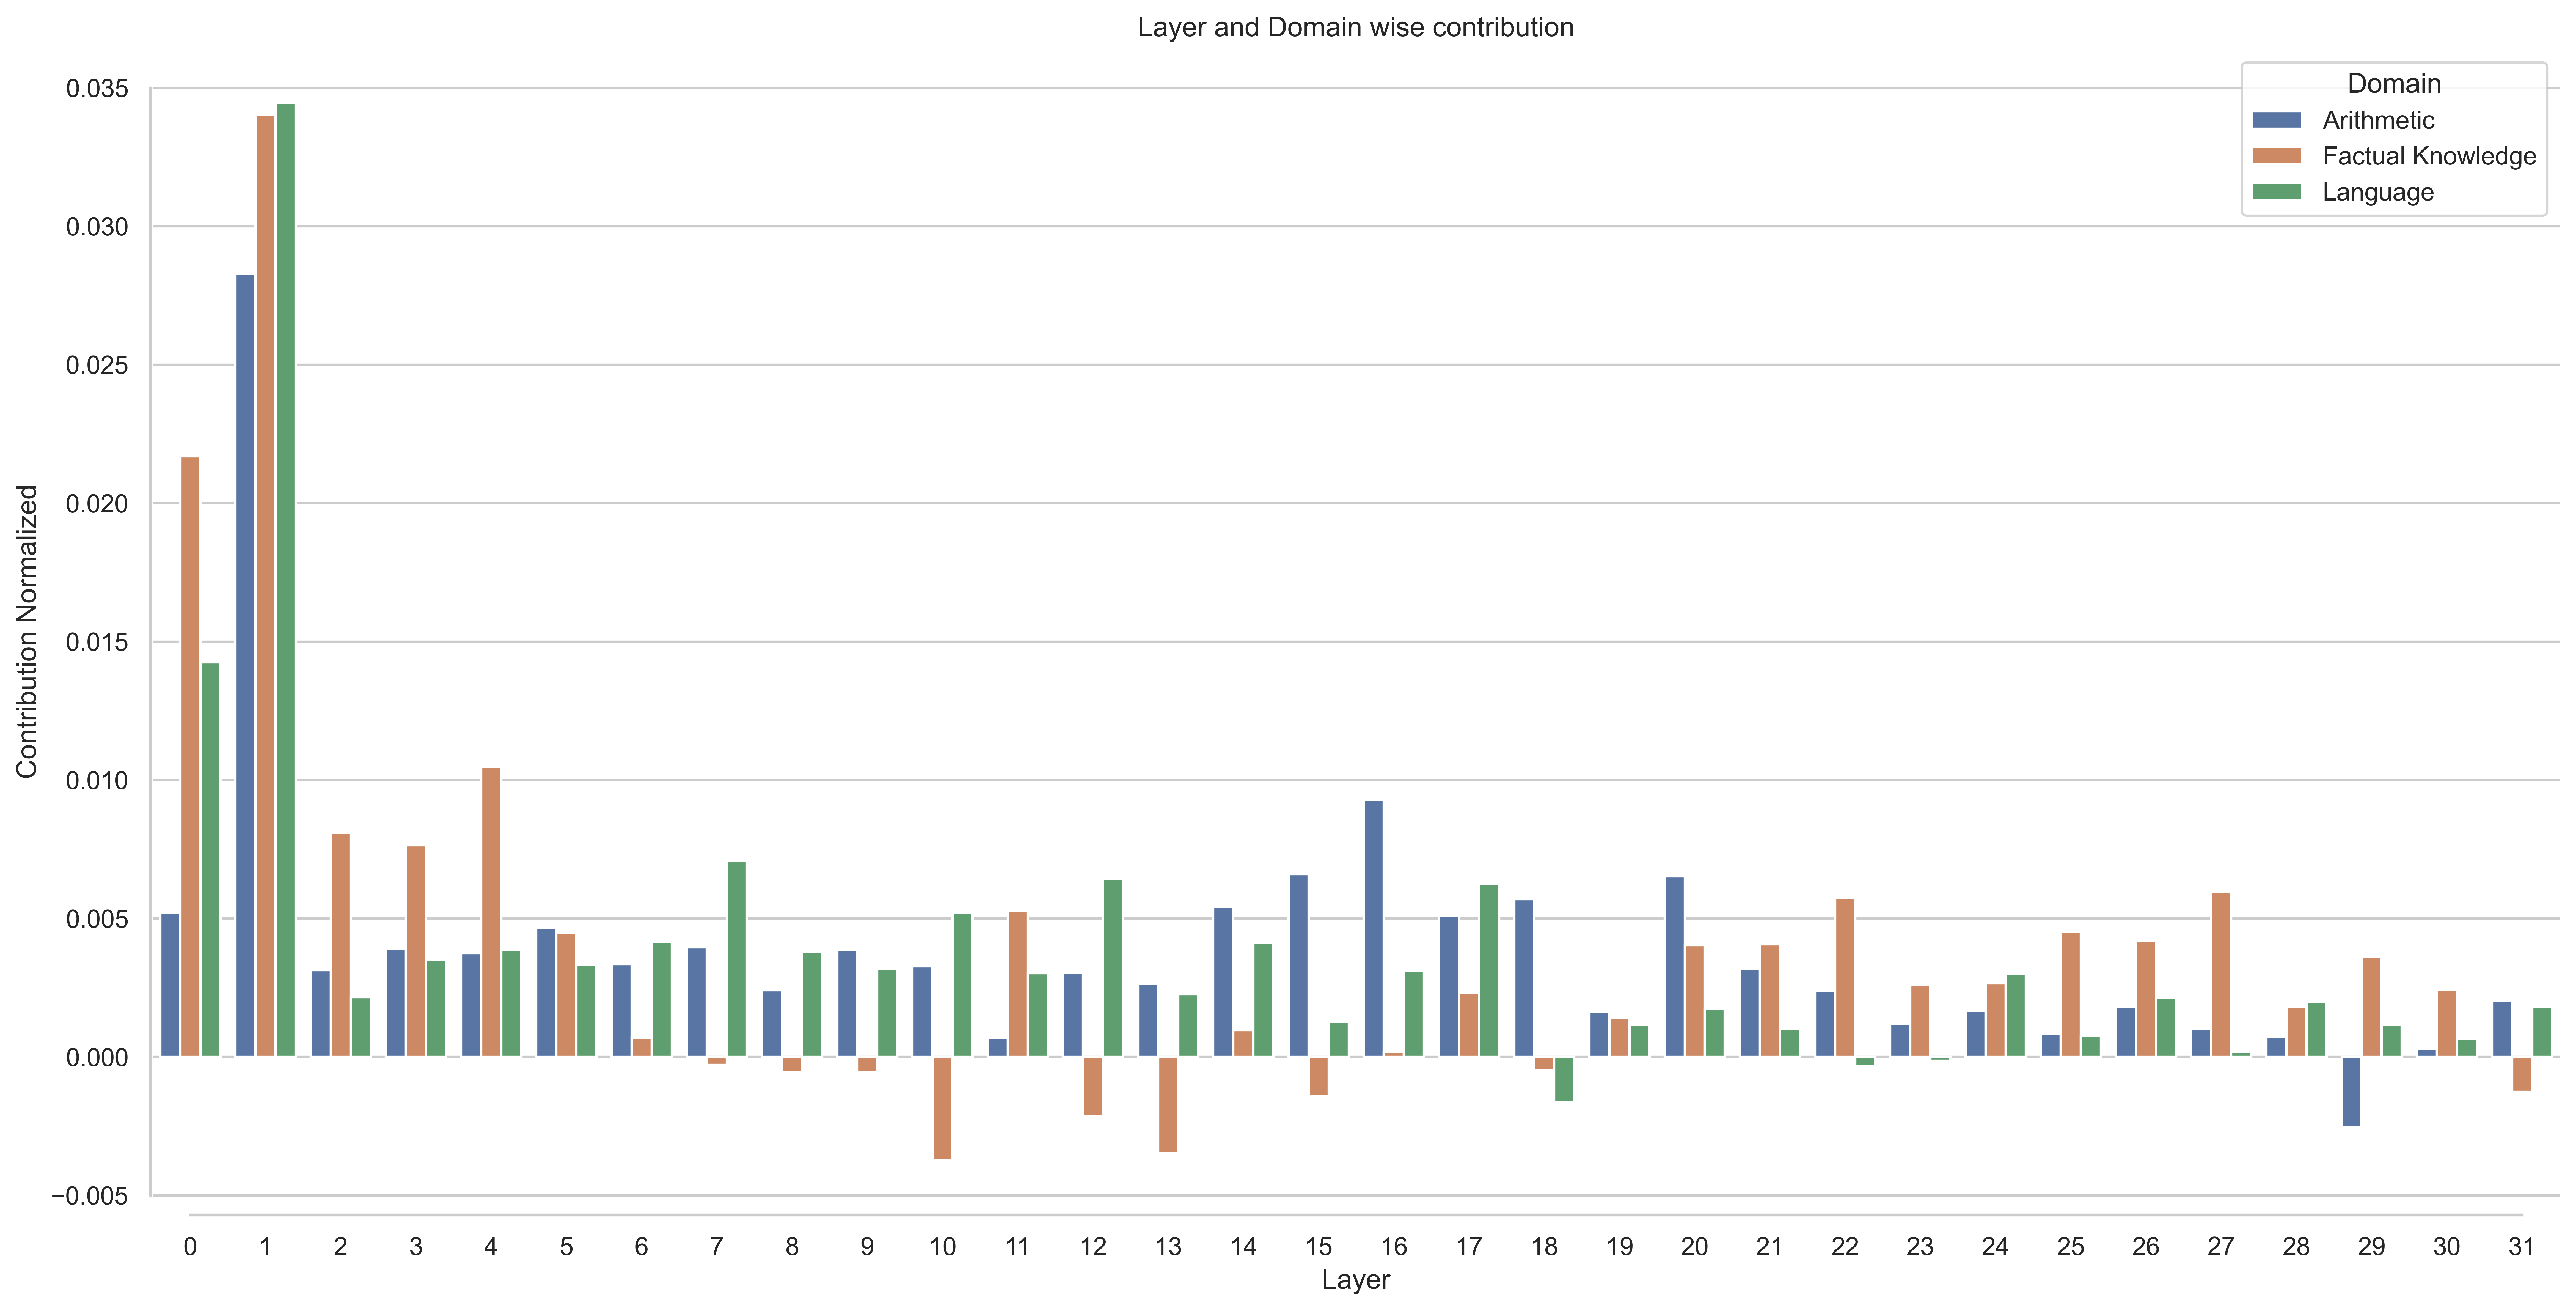

In [32]:
layer_and_task_wise_contributions = domain_wise_df.groupby(["Layer", "Domain"])["Contribution Normalized"].mean().reset_index()

plt.figure(figsize=(40*CM,20*CM), dpi = 600)
sns.set_theme(style="whitegrid")
sns.barplot(data=layer_and_task_wise_contributions, x="Layer", y="Contribution Normalized", hue="Domain")
sns.despine(offset=1, trim=True)
plt.tight_layout(pad=1)
plt.title("Layer and Domain wise contribution")
plt.savefig("Figures/layer_and_domain_wise_contribution.pdf", dpi=600,bbox_inches='tight')
plt.show()

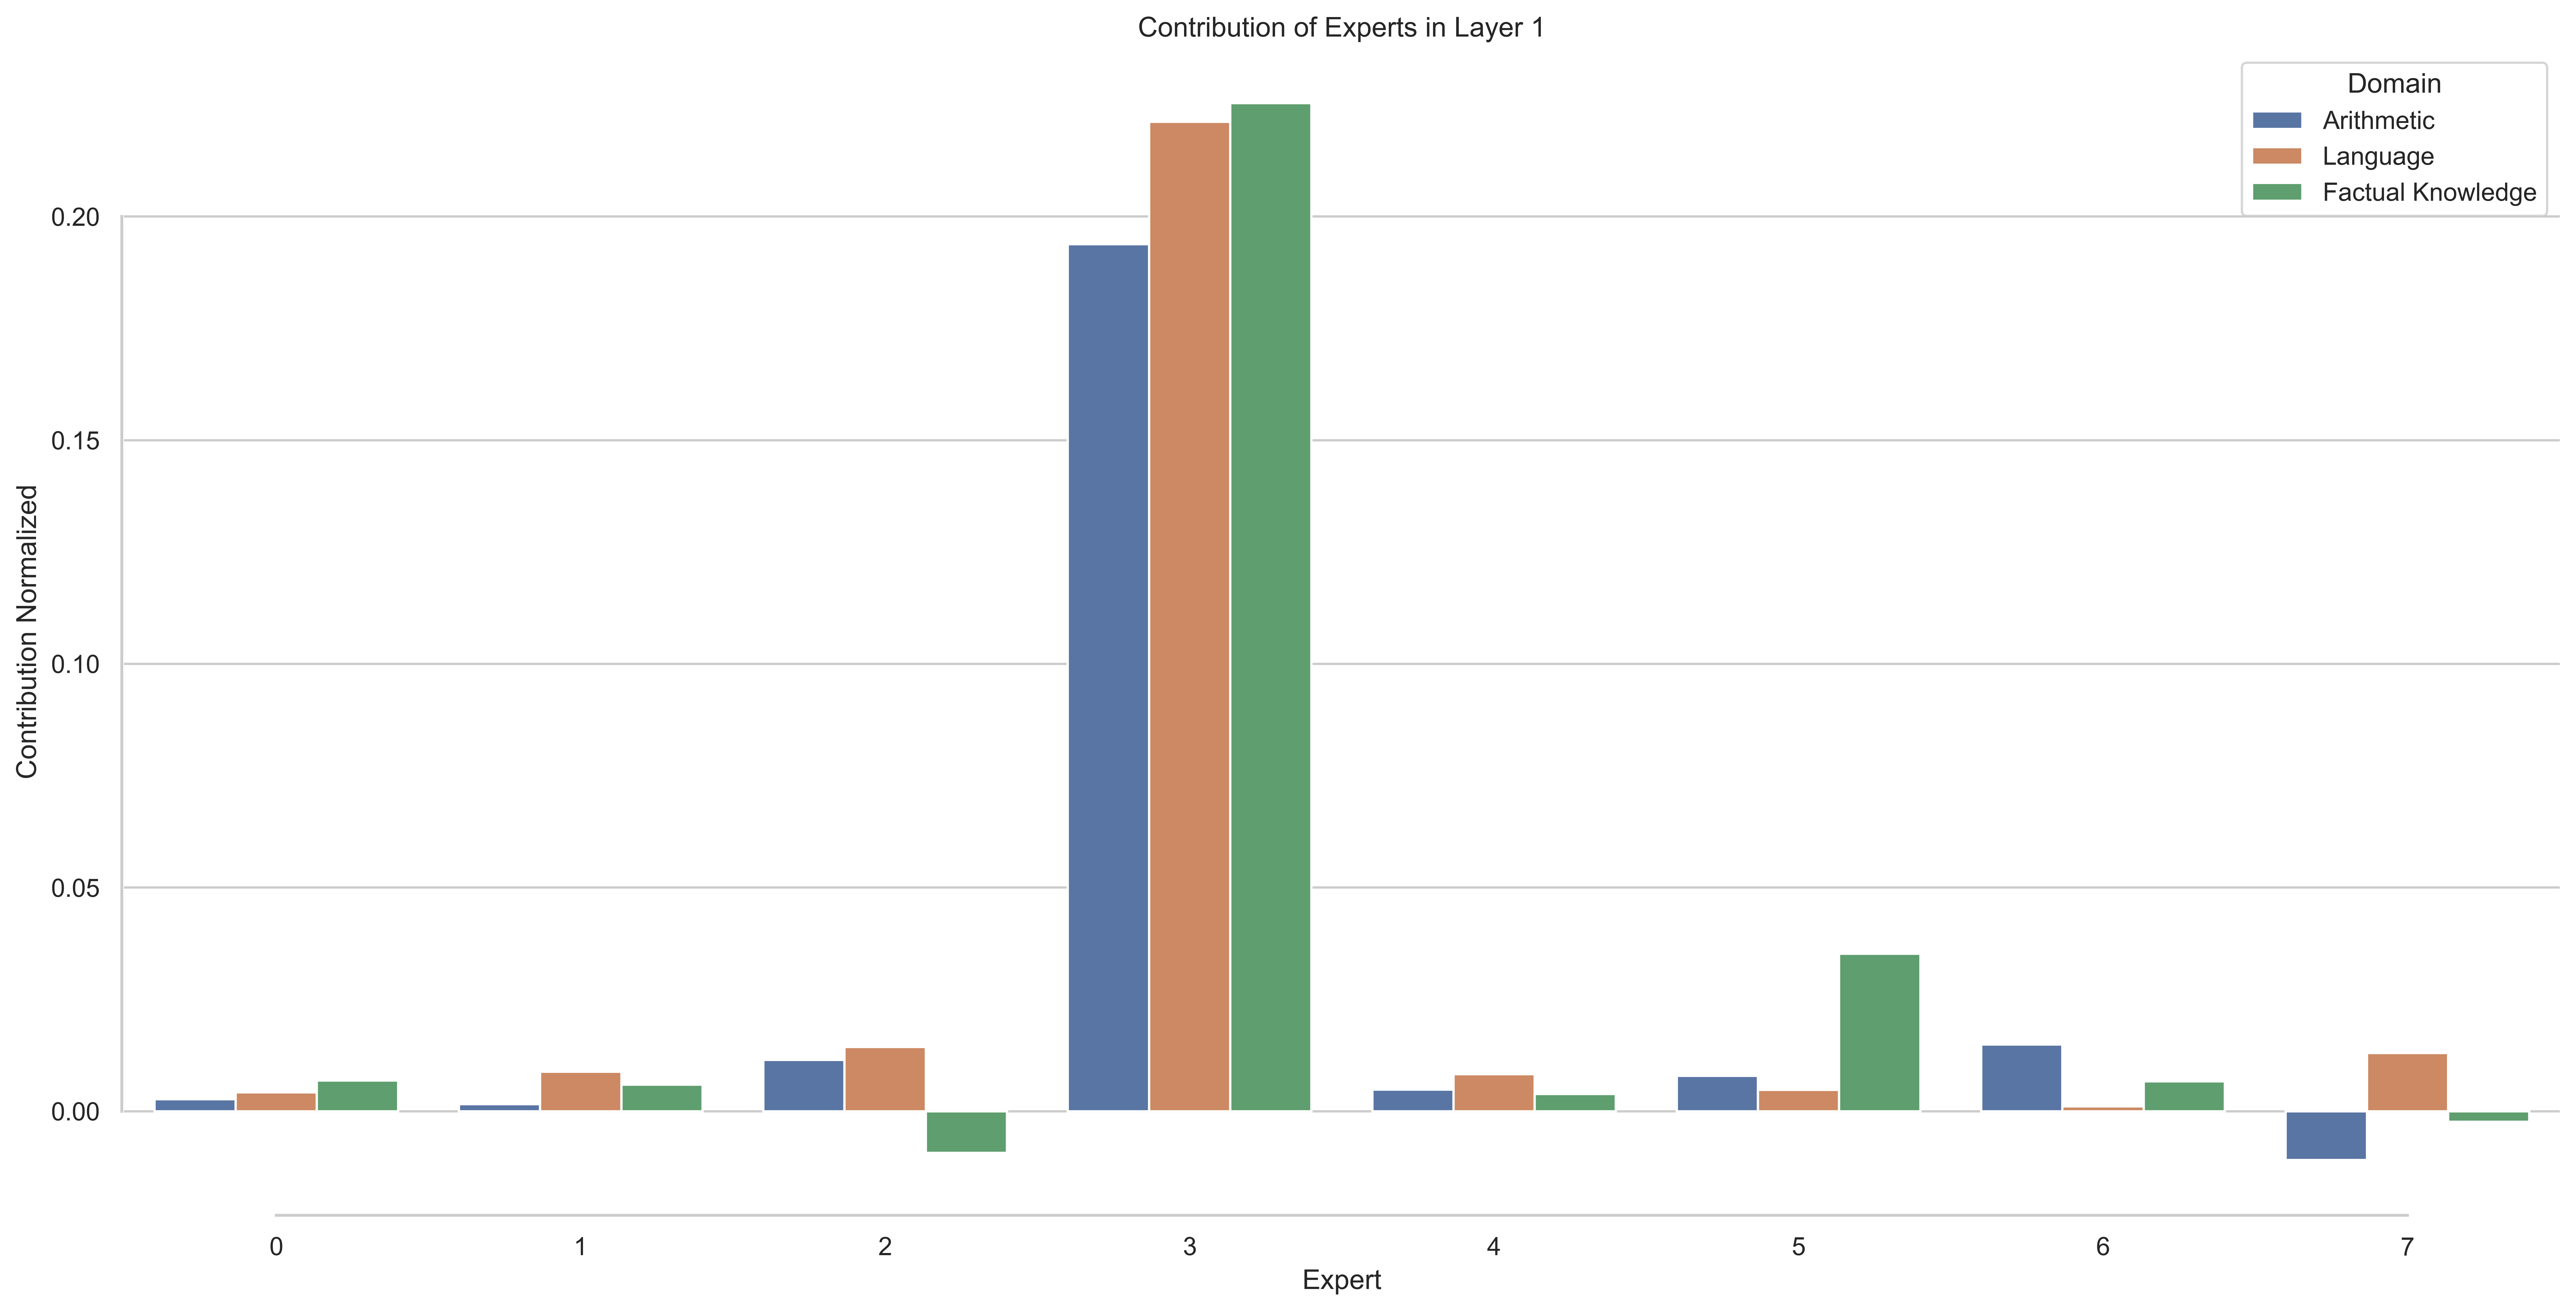

In [33]:
layer_and_task_wise_contributions = domain_wise_df[domain_wise_df["Layer"] == 1]

plt.figure(figsize=(40*CM,20*CM), dpi = 600)
sns.set_theme(style="whitegrid")
sns.barplot(data=layer_and_task_wise_contributions, x="Expert", y="Contribution Normalized", hue="Domain")
sns.despine(offset=1, trim=True)
plt.tight_layout(pad=1)
plt.title("Contribution of Experts in Layer 1")
plt.savefig("Figures/contribution_of_experts_in_layer_1.pdf", dpi=600,bbox_inches='tight')
plt.show()

In [34]:
LesionedModelPerformance(*list(objective_function(((1, 0), (1, 1), (1, 2), (1, 4), (1, 5), (1, 6), (1, 7)))))

LesionedModelPerformance(
  addition_accuracy=0.9011,
  subtraction_accuracy=0.9076,
  multiplication_accuracy=0.5174,
  english_accuracy=1.0000,
  german_accuracy=0.9333,
  french_accuracy=1.0000,
  spanish_accuracy=0.8000,
  italian_accuracy=1.0000,
  country_capital_accuracy=0.8500
)

In [9]:
(0.9011+0.9076+0.5174+1.0000+0.9333+1.0000+0.8000+1.0000+0.8500) / 9

0.8788222222222221

In [35]:
LesionedModelPerformance(*list(objective_function(((1, 3),))))

LesionedModelPerformance(
  addition_accuracy=0.8484,
  subtraction_accuracy=0.8932,
  multiplication_accuracy=0.4869,
  english_accuracy=0.9333,
  german_accuracy=0.7333,
  french_accuracy=0.9333,
  spanish_accuracy=0.6000,
  italian_accuracy=0.3333,
  country_capital_accuracy=0.7000
)

In [36]:
(0.8484+0.8932+0.4869+0.9333+0.7333+0.9333+0.6000+0.3333+0.7000) / 9

0.7179666666666668

In [14]:
0.8788222222222221 - 0.7179666666666668

0.1608555555555553

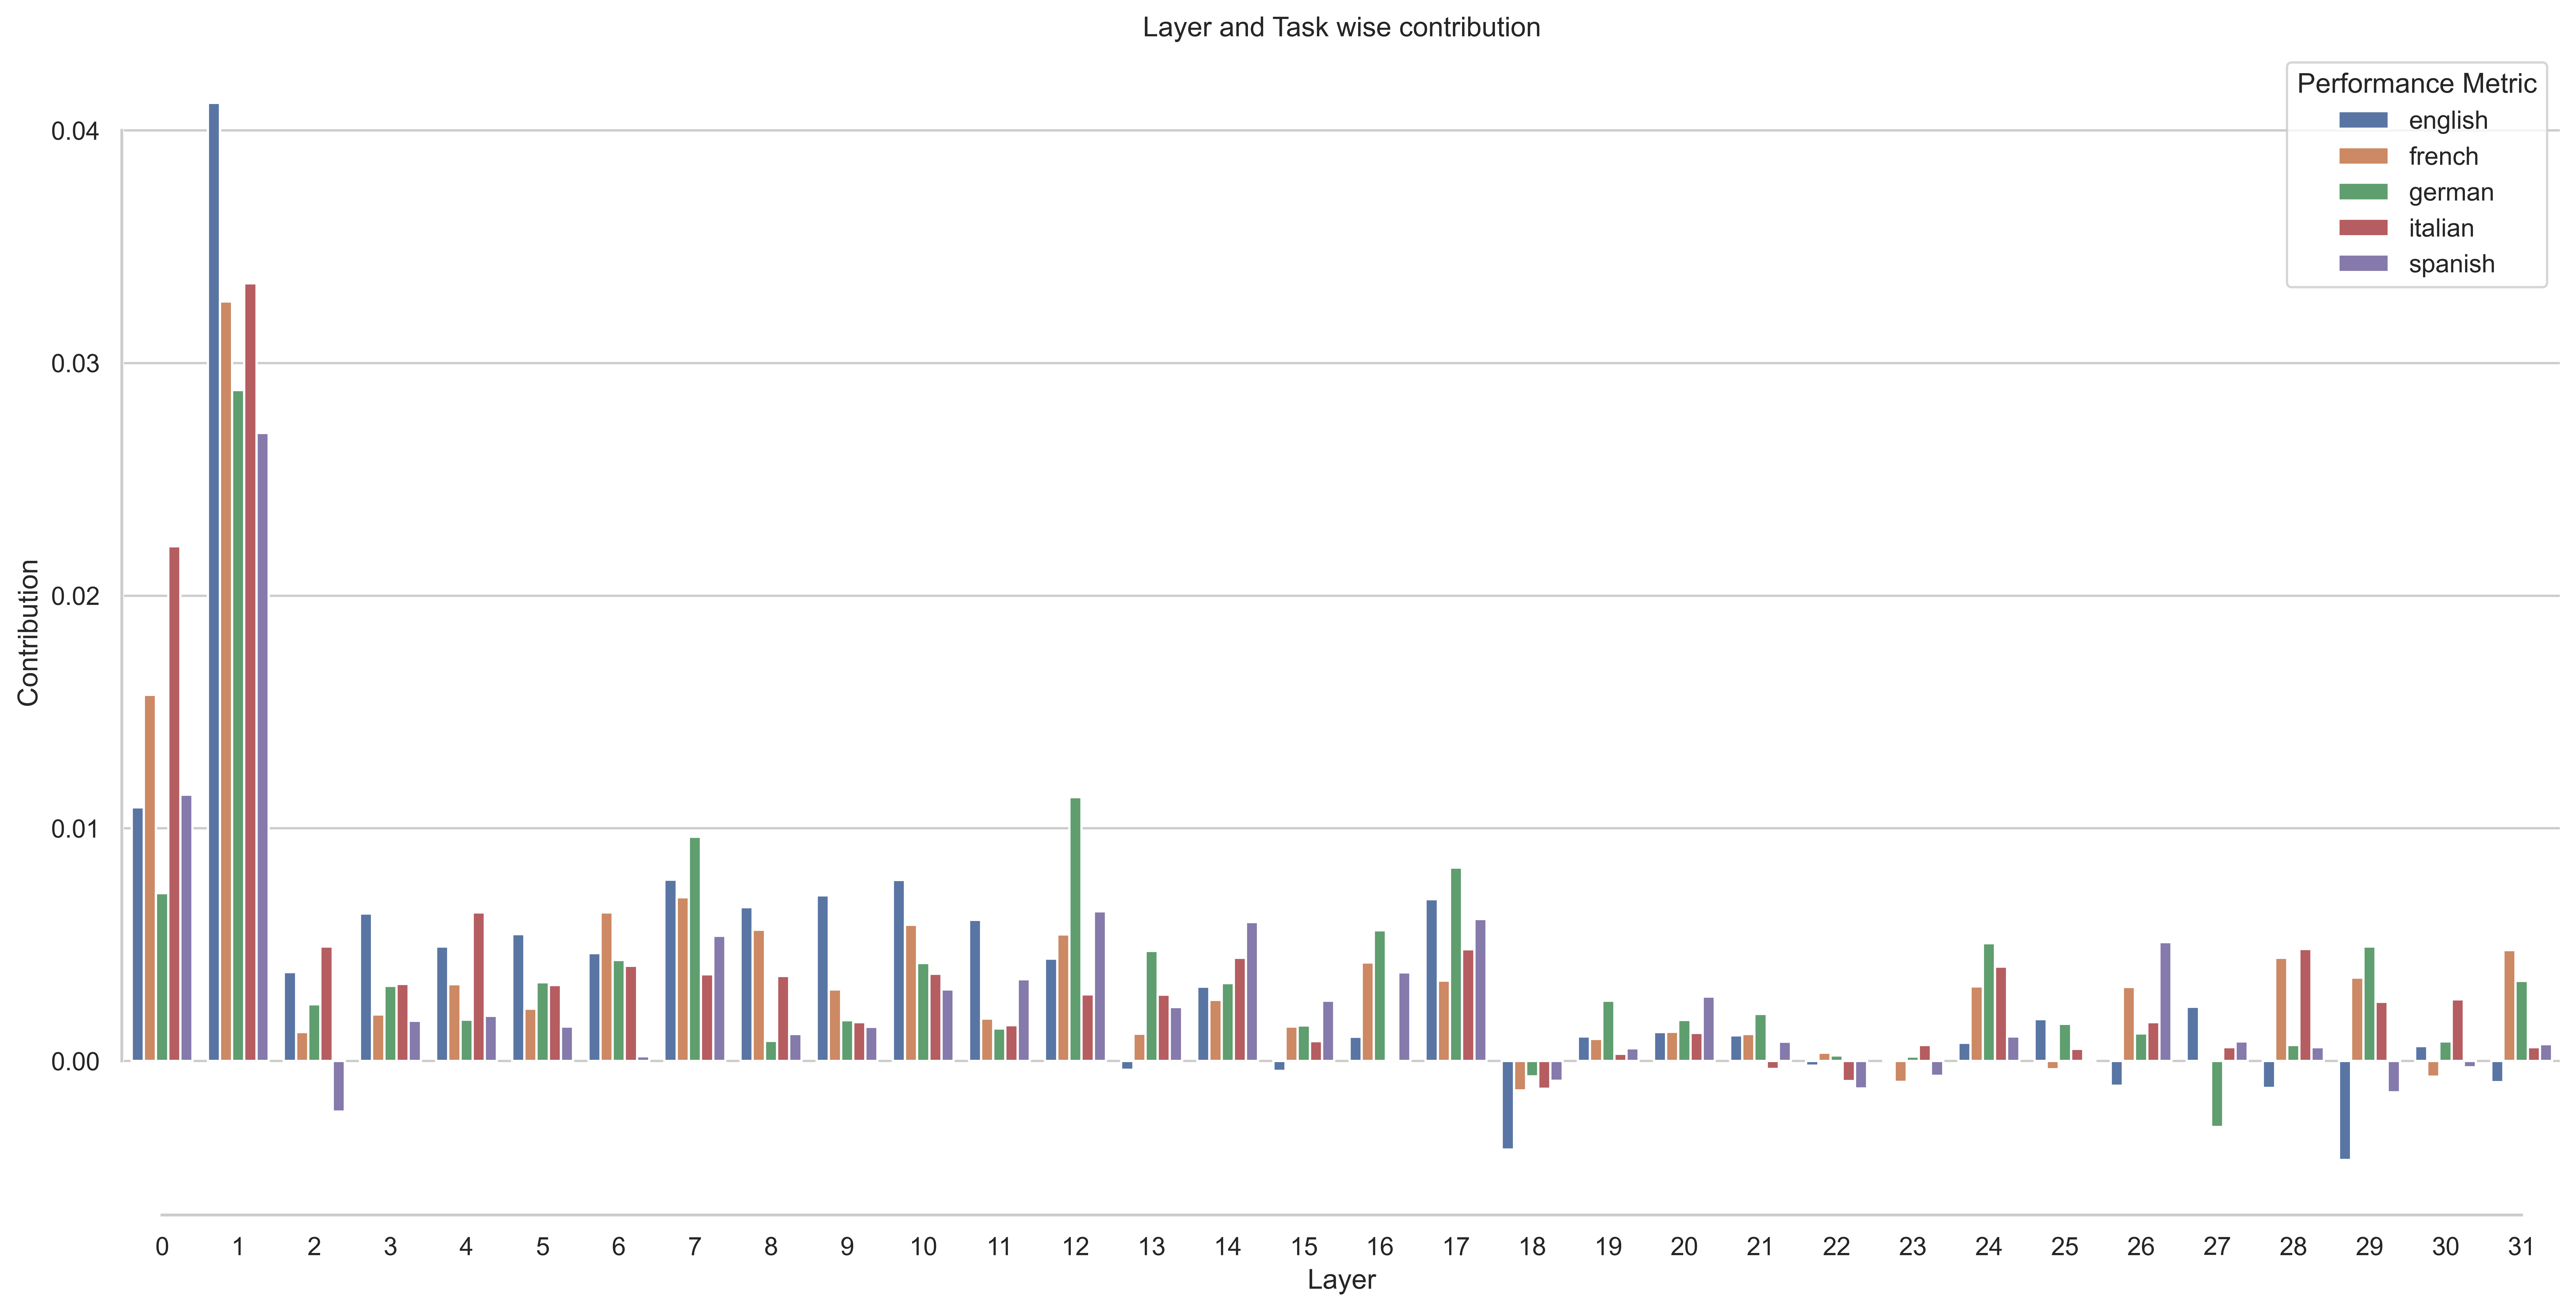

In [38]:
layer_and_task_wise_contributions = shapley_df_formatted.groupby(["Layer", "Performance Metric"])["Contribution"].mean().reset_index()

# Take only language Performance Metrics
layer_and_task_wise_contributions = layer_and_task_wise_contributions[layer_and_task_wise_contributions["Performance Metric"].isin(["english", "german", "french", "spanish", "italian"])]

plt.figure(figsize=(40*CM,20*CM), dpi = 600)
sns.set_theme(style="whitegrid")
sns.barplot(data=layer_and_task_wise_contributions, x="Layer", y="Contribution", hue="Performance Metric")
sns.despine(offset=1, trim=True)
plt.tight_layout(pad=1)
plt.title("Layer and Task wise contribution")
plt.show()

In [39]:
def get_output_from_lesioned_model(message, complements, max_new_tokens):
    message = tokenizer.apply_chat_template(message, return_tensors="pt", padding=True)
    complements_to_lesion_dict(complements)
    output = lesioned_model.generate(message, max_new_tokens=max_new_tokens, pad_token_id = tokenizer.eos_token_id)
    output = tokenizer.batch_decode(output, skip_special_tokens=True)
    return output[0]

In [40]:
german_shapley_df = shapley_df_formatted[shapley_df_formatted["Performance Metric"] == "german"].reset_index()
german_shapley_df["German_Contribution - Average Arithmetic"]  = german_shapley_df["Contribution"] - average_arithmetic_shapley_df["Contribution"]

german_shapley_df["German_Contribution - Average Language"]  = german_shapley_df["Contribution"] - average_language_shapley_df["Contribution"]

german_shapley_df["German_Contribution - Average World"]  = german_shapley_df["Contribution"] - average_world_shapley_df["Contribution"]
german_shapley_df.sort_values(by="German_Contribution - Average Arithmetic", ascending=False).head(7)

,index,Contribution,Performance Metric,Layer,Expert,German_Contribution - Average Arithmetic,German_Contribution - Average Language,German_Contribution - Average World
11,103,0.218571,german,1,3,0.063352,0.009238,0.035071
143,1291,0.061524,german,17,7,0.050860,0.021429,0.055167
196,1768,0.039714,german,24,4,0.040262,0.018933,0.040214
97,877,0.036095,german,12,1,0.030904,0.020248,0.053238
237,2137,0.016476,german,29,5,0.026082,0.015276,0.025690
236,2128,0.023333,german,29,4,0.024104,0.017733,0.020190
100,904,0.020857,german,12,4,0.020050,0.007067,0.024214


In [41]:
german_specific_experts = ((24, 4), (12, 1), (29, 5), (17, 7))
LesionedModelPerformance(*list(objective_function(german_specific_experts)))

LesionedModelPerformance(
  addition_accuracy=0.8897,
  subtraction_accuracy=0.9062,
  multiplication_accuracy=0.5943,
  english_accuracy=1.0000,
  german_accuracy=0.2667,
  french_accuracy=1.0000,
  spanish_accuracy=0.7333,
  italian_accuracy=1.0000,
  country_capital_accuracy=0.9000
)

In [42]:
countries_population_task_message_german = [
    {
        "role": "user",
        "content": "Nennen Sie die zehn meisten bevoelkerungsreichsten Länder. Sie sollten Sie prägnant und antworten Sie auf Deutsch"
    }
]

print(get_output_from_lesioned_model(countries_population_task_message_german, [], 200))

[INST] Nennen Sie die zehn meisten bevoelkerungsreichsten Länder. Sie sollten Sie prägnant und antworten Sie auf Deutsch [/INST] Hier die zehn Länder mit der größten Bevölkerung (Stand 2021):

1. China
2. Indien
3. Vereinigte Staaten
4. Indonesien
5. Pakistan
6. Brasilien
7. Nigeria
8. Bangladesch
9. Russland
10. Mexiko

Die Reihenfolge kann je nach verwendeter Datenquelle und Berechnungsmethode leicht variieren.


In [43]:
print(get_output_from_lesioned_model(countries_population_task_message_german, ((17, 7), ), 200))

[INST] Nennen Sie die zehn meisten bevoelkerungsreichsten Länder. Sie sollten Sie prägnant und antworten Sie auf Deutsch [/INST] Here are the ten most populous countries as of 2021:

1. China - approximately 1.4 billion people
2. India - approximately 1.3 billion people
3. United States - approximately 331 million people
4. Indonesia - approximately 273 million people
5. Pakistan - approximately 225 million people
6. Brazil - approximately 212 million people
7. Nigeria - approximately 206 million people
8. Bangladesh - approximately 165 million people
9. Russia - approximately 146 million people
10. Mexico - approximately 128 million people

Please note that these numbers are approximate and can vary slightly.


In [44]:
short_story_message_german = [
    {
        "role": "user",
        "content": "Erzähl mir eine sehr kurze Geschichte auf Deutsch. Schreiben Sie die Geschichte nicht auf Englisch"
    }
]

print(get_output_from_lesioned_model(short_story_message_german, [], 200))

[INST] Erzähl mir eine sehr kurze Geschichte auf Deutsch. Schreiben Sie die Geschichte nicht auf Englisch [/INST] once upon a time in a small Dorf, there lived a armer Mann named Karl. Er hatte keine Familie und arbeitete hart auf seiner Farm every day. Eines Tages, als er sein Getreide erntete, sah er ein schwaches Kätzchen in den Feldern umherirren. Es war offensichtlich verhungert und allein. Karl, mit einem Herz aus Gold, konnte nicht zulassen, dass das Kätzchen so leidet. Er nahm das Kätzchen auf und kümmerte sich um es. Er gab ihm Futter und ein Zuhause. Das Kätzchen wuchs und wurde zu einem starken und gesunden Kater. Karl und der Kater wurden die besten Freunde und arbeiteten zusammen auf der Farm. Dank des Katers, der Mäuse hielt, war Karls Ernte reichlich und sein


In [45]:
short_story_message_german = [
    {
        "role": "user",
        "content": "Erzähl mir eine sehr kurze Geschichte auf Deutsch. Schreiben Sie die Geschichte nicht auf Englisch"
    }
]

print(get_output_from_lesioned_model(short_story_message_german, ((24, 4), (17, 7)), 200))

[INST] Erzähl mir eine sehr kurze Geschichte auf Deutsch. Schreiben Sie die Geschichte nicht auf Englisch [/INST] Once upon a time in a small German village, there was an old baker who made the most delicious bread. People came from far and wide to buy his bread, and he was known throughout the land for his talent.

One day, a young girl came into the bakery and asked for a loaf of bread. The baker asked her what kind of bread she would like, and she replied, "I would like the most delicious bread you have ever made."

The baker smiled and said, "I have been making bread for many years, and I have never made the same bread twice. But today, I will make a special loaf just for you."

He worked all day, using only the finest ingredients and his most closely guarded techniques. When the bread was finally finished, he presented it to the young girl.

She took a bite and exclaimed, "This is the most delicious bread I have ever tasted!"



In [46]:
spanish_shapley_df = shapley_df_formatted[shapley_df_formatted["Performance Metric"] == "spanish"].reset_index()
non_spanish_languages_shapley_df = language_shapley_df[language_shapley_df["Performance Metric"] != "spanish"].reset_index()
spanish_shapley_df["spanish_Contribution - Average Arithmetic"]  = spanish_shapley_df["Contribution"] - average_arithmetic_shapley_df["Contribution"]
spanish_shapley_df["spanish_Contribution - Other Languages"]  = spanish_shapley_df["Contribution"] - non_spanish_languages_shapley_df["Contribution"]
spanish_shapley_df["spanish_Contribution - German_Contribution"]  = spanish_shapley_df["Contribution"] - german_shapley_df["Contribution"]

spanish_shapley_df["spanish_Contribution - Average Language"]  = spanish_shapley_df["Contribution"] - average_language_shapley_df["Contribution"]

spanish_shapley_df["spanish_Contribution - Average World"]  = spanish_shapley_df["Contribution"] - average_world_shapley_df["Contribution"]
spanish_shapley_df.sort_values(by="spanish_Contribution - Average Arithmetic", ascending=False).head(7)

,index,Contribution,Performance Metric,Layer,Expert,spanish_Contribution - Average Arithmetic,spanish_Contribution - Other Languages,spanish_Contribution - German_Contribution,spanish_Contribution - Average Language,spanish_Contribution - Average World
3,33,0.036190,spanish,0,3,0.036170,0.032286,0.018190,0.005657,0.015976
1,15,0.055333,spanish,0,1,0.032238,0.056095,0.025714,-0.009638,-0.052810
213,1923,0.029143,spanish,26,5,0.028724,0.027619,0.027429,0.018076,0.024214
89,807,0.026571,spanish,11,1,0.019068,0.026381,0.004000,0.008571,0.010214
59,537,0.017810,spanish,7,3,0.018930,0.014762,0.002952,0.003067,0.012595
143,1293,0.028667,spanish,17,7,0.018003,0.024762,-0.032857,-0.011429,0.022310
69,627,0.009429,spanish,8,5,0.013055,0.003429,0.005429,-0.004362,0.009643


In [47]:
spanish_specific_experts = ((26, 5), (11, 1), (7, 3), (8, 5))
LesionedModelPerformance(*list(objective_function(spanish_specific_experts)))

LesionedModelPerformance(
  addition_accuracy=0.9095,
  subtraction_accuracy=0.9336,
  multiplication_accuracy=0.5671,
  english_accuracy=1.0000,
  german_accuracy=0.9333,
  french_accuracy=0.8667,
  spanish_accuracy=0.3333,
  italian_accuracy=1.0000,
  country_capital_accuracy=0.7500
)

In [48]:
short_story_message_spanish = [
    {
        "role": "user",
        "content": "Cuéntame una historia muy corta en español. No escribas la historia en inglés."
    }
]

print(get_output_from_lesioned_model(short_story_message_spanish, [], 200))

[INST] Cuéntame una historia muy corta en español. No escribas la historia en inglés. [/INST] Había una vez una pequeña mariposa que anhelaba volar más alto y más lejos que cualquier otra mariposa. A pesar de su pequeño tamaño, su deseo era grande. Un día, decidió emprender un largo viaje en busca de las montañas más elevadas.

Durante su travesía, se topó con todo tipo de obstáculos y desafíos. Sin embargo, su determinación era tan fuerte que siempre encontraba la forma de superarlos. Llegó a las montañas y, con gran alegría, comenzó a volar aún más alto que antes.

Un día, mientras volaba, vio a lo lejos un hermoso prado lleno de flores. Decidió bajar para descansar y beber néctar. En ese prado


In [49]:
short_story_message_spanish = [
    {
        "role": "user",
        "content": "Cuéntame una historia muy corta en español. No escribas la historia en inglés."
    }
]

print(get_output_from_lesioned_model(short_story_message_spanish, spanish_specific_experts, 200))

[INST] Cuéntame una historia muy corta en español. No escribas la historia en inglés. [/INST] Una vez upon a time, in a small village, there was a kind and generous farmer. He had the most beautiful garden, full of vibrant flowers and delicious fruits. The farmer was known throughout the land for his generosity, as he would share his crops with everyone in the village.

One day, a terrible drought struck the village, and the crops began to wilt and die. The farmer knew that the villagers would have nothing to eat, so he decided to plant his own crops in the village square. He worked day and night, watering and caring for the plants, until they bloomed into a sea of color and life.

The villagers were amazed and grateful for the farmer's selflessness. They asked him how he could be so generous, even in the face of such hardship. The farmer replied, "We are all in this together. If I have food, then I must share it. That is the only way we


<Figure size 9448.82x4724.41 with 0 Axes>

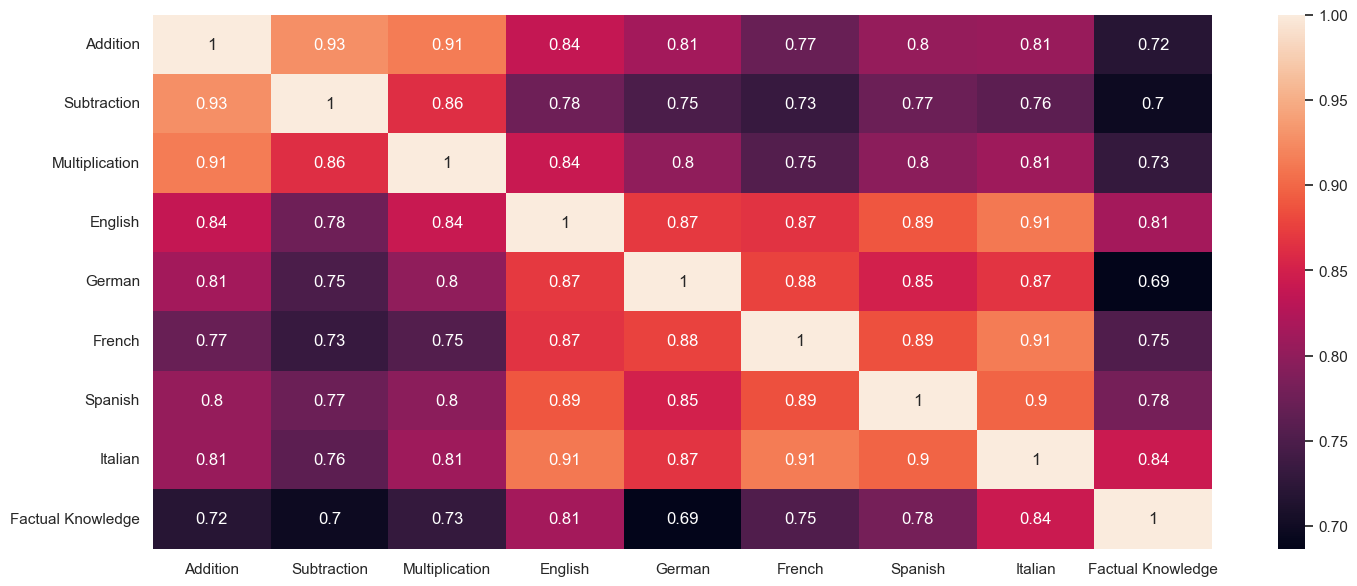

In [50]:
columns_rearranged = ["addition", "subtraction", "multiplication", "english", "german", "french", "spanish", "italian", "country_capital"]
shapley_df_formatted_pivot = shapley_df_formatted.pivot(columns="Performance Metric", values="Contribution", index=["Layer", "Expert"])[columns_rearranged]
shapley_df_formatted_pivot.columns = ["Addition", "Subtraction", "Multiplication", "English", "German", "French", "Spanish", "Italian", "Factual Knowledge"]

# Find the correlation matrix between the performance metrics
correlation = np.corrcoef(shapley_df_formatted_pivot.values, rowvar=False)
correlation = np.nan_to_num(correlation)
plt.figure(figsize=(40*CM,20*CM), dpi = 600)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))
sns.heatmap(correlation, xticklabels=shapley_df_formatted_pivot.columns, yticklabels=shapley_df_formatted_pivot.columns, annot=True)
plt.tight_layout(pad=1)
plt.savefig("Figures/Correlation among Tasks.pdf", dpi=600,bbox_inches='tight')

In [52]:
import json

with open("accuracies_low.json", "r") as f:
    accuracies_low = json.load(f)

with open("accuracies_high.json", "r") as f:
    accuracies_high = json.load(f)

In [53]:
accuracies_df_low = pd.DataFrame(accuracies_low)
accuracies_df_high = pd.DataFrame(accuracies_high)

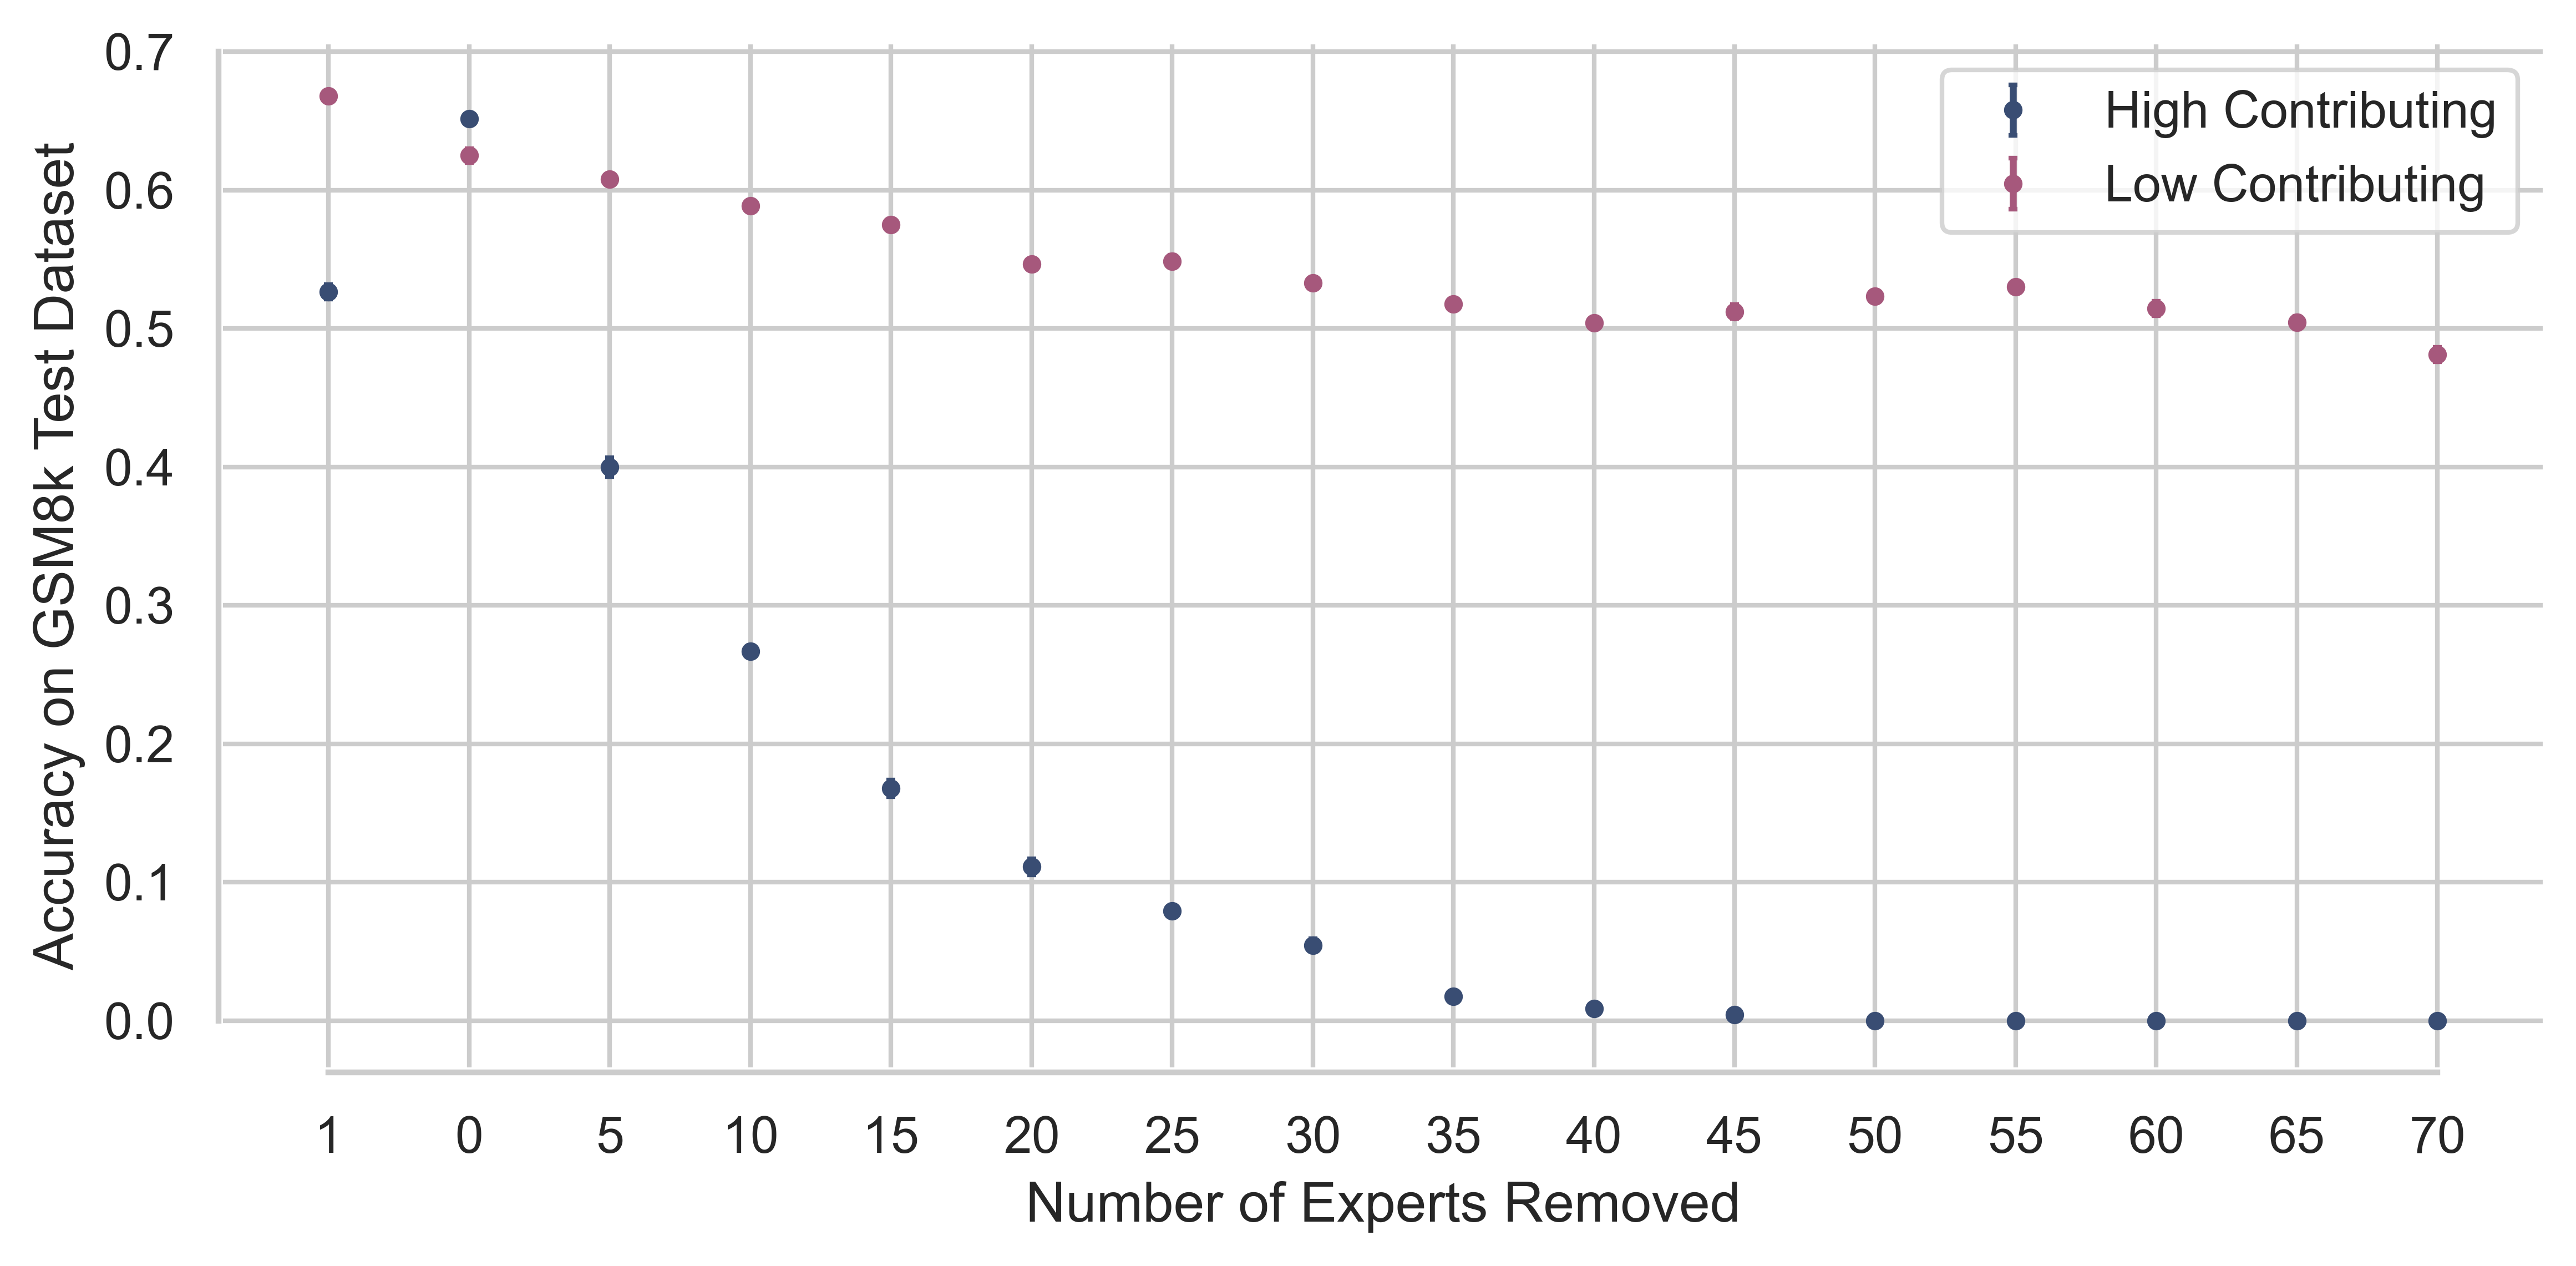

In [56]:
plt.figure(figsize=(20*CM,10*CM),dpi = 600)
plt.errorbar(x=accuracies_df_high.columns, y=accuracies_df_high.mean(), fmt='.', yerr=accuracies_df_high.std(), capsize=1, color = NIGHT_BLUE, label="High Contributing")
plt.errorbar(x=accuracies_df_low.columns, y=accuracies_df_low.mean(), fmt='.', yerr=accuracies_df_low.std(), capsize=1, color = PURPLE, label="Low Contributing")
plt.legend()
plt.xlabel("Number of Experts Removed")
plt.ylabel("Accuracy on GSM8k Test Dataset")

sns.despine(offset=1, trim=True)
plt.tight_layout(pad=1)

#plt.savefig(f"Figures/Accuracy on GSM8k Test Dataset After Removing Experts.pdf",dpi=600,bbox_inches='tight')